#### reference code: https://github.com/omerferhatt/torch2tflite

## ONNX를 이용하여 pytorch 모델을 tflite 모델로 변환하는 과정을 진행해 본다.
### 실습 서버에서는 설치가 잘 안 될 수 있으므로 코랩이나 다른 환경에서 진행

In [ ]:
!pip uninstall tensorflow -y
!pip uninstall torch -y

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
Uninstalling torch-1.8.1+cu101:
  Successfully uninstalled torch-1.8.1+cu101


In [ ]:
! pip install -q tf-nightly
!pip install tensorflow-addons==0.11.2
!pip install torch==1.7.0
!pip install onnx==1.8.0
!pip install onnx-tf==1.7.0

     |████████████████████████████████| 320.4MB 44kB/s 
     |████████████████████████████████| 460kB 47.9MB/s 
     |████████████████████████████████| 20.1MB 1.4MB/s 
ERROR: torchvision 0.9.1+cu101 requires torch==1.8.1, which is not installed.
ERROR: torchtext 0.9.1 requires torch==1.8.1, which is not installed.
ERROR: fastai 1.0.61 requires torch>=1.0.0, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


     |████████████████████████████████| 1.1MB 18.6MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0 which is incompatible.
     |████████████████████████████████| 7.7MB 9.2MB/s 
     |████████████████████████████████| 215kB 16.0MB/s 


### install 후에는 kernel restart 할 것

In [ ]:
import os
import shutil
import sys

import cv2
import numpy as np
import onnx
import tensorflow as tf
import torch
from PIL import Image
from onnx_tf.backend import prepare
from torchvision import transforms

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.6.0-dev20210418). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


Helper Functions

In [ ]:
def get_example_input(image_file):
    """
    Loads image from disk and converts to compatible shape.
    :param image_file: Path to single image file
    :return: Original image, numpy.ndarray instance image, torch.Tensor image
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(image)
    torch_img = transform(pil_img)
    torch_img = torch_img.unsqueeze(0)
    torch_img = torch_img.to(torch.device("cpu"))

    return image, torch_img.numpy(), torch_img


In [ ]:
def torch_to_onnx(torch_path, onnx_path, image_path):
    """
    Converts PyTorch model file to ONNX with usable op-set
    :param torch_path: Torch model path to load
    :param onnx_path: ONNX model path to save
    :param image_path: Path of test image to use in export progress
    """
    pytorch_model = get_torch_model(torch_path)
    image, tf_lite_image, torch_image = get_example_input(image_path)

    torch.onnx.export(
        model=pytorch_model,
        args=torch_image,
        f=onnx_path,
        verbose=False,
        export_params=True,
        do_constant_folding=False,  # fold constant values for optimization
        input_names=['input'],
        opset_version=10,
        output_names=['output'])

In [ ]:
def onnx_to_tf(onnx_path, tf_path):
    """
    Converts ONNX model to TF 2.X saved file
    :param onnx_path: ONNX model path to load
    :param tf_path: TF path to save
    """
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)  # Checks signature
    tf_rep = prepare(onnx_model)  # Prepare TF representation
    tf_rep.export_graph(tf_path)  # Export the model

In [ ]:
def tf_to_tf_lite(tf_path, tf_lite_path):
    """
    Converts TF saved model into TFLite model
    :param tf_path: TF saved model path to load
    :param tf_lite_path: TFLite model path to save
    """
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)  # Path to the SavedModel directory
    tflite_model = converter.convert()  # Creates converter instance
    with open(tf_lite_path, 'wb') as f:
        f.write(tflite_model)

In [ ]:
def get_torch_model(model_path):
    """
    Loads state-dict into model and creates an instance
    :param model_path: State-dict path to load PyTorch model with pre-trained weights
    :return: PyTorch model instance
    """
    model = torch.load(model_path, map_location='cpu')
    return model

In [ ]:
def get_tf_lite_model(model_path):
    """
    Creates an instance of TFLite CPU interpreter
    :param model_path: TFLite model path to initialize
    :return: TFLite interpreter
    """
    interpret = tf.lite.Interpreter(model_path)
    interpret.allocate_tensors()
    return interpret

In [ ]:
def predict_torch(model, image):
    """
    Torch model prediction (forward propagate)
    :param model: PyTorch model
    :param image: Input image
    :return: Numpy array with logits
    """
    return model(image).data.cpu().numpy()

In [ ]:
def predict_tf_lite(model, image):
    """
    TFLite model prediction (forward propagate)
    :param model: TFLite interpreter
    :param image: Input image
    :return: Numpy array with logits
    """
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    model.set_tensor(input_details[0]['index'], image)
    model.invoke()
    tf_lite_output = model.get_tensor(output_details[0]['index'])
    return tf_lite_output

In [ ]:
def calc_error(res1, res2, verbose=False):
    """
    Calculates specified error between two results. In here Mean-Square-Error and Mean-Absolute-Error calculated"
    :param res1: First result
    :param res2: Second result
    :param verbose: Print loss results
    :return: Loss metrics as a dictionary
    """
    mse = ((res1 - res2) ** 2).mean(axis=None)
    mae = np.abs(res1 - res2).mean(axis=None)
    metrics = {'mse': mse, 'mae': mae}
    if verbose:
        print(f"Mean-Square-Error between predictions: {metrics['mse']}")
        print(f"Mean-Absolute-Error between predictions: {metrics['mae']}\n")
    return metrics

In [ ]:
def convert(torch_model_path, tf_lite_model_path, image_path):
    if os.path.exists('output'):
        shutil.rmtree('output')
        os.mkdir('output')
    else:
        os.mkdir('output')
    ONNX_PATH = "output/onnx_model.onnx"
    TF_PATH = "output/tf_model"

    try:
        torch_to_onnx(torch_path=torch_model_path, onnx_path=ONNX_PATH, image_path=image_path)
        print('\n\nTorch to ONNX converted!\n\n')
    except Exception as e:
        print(e)
        sys.exit(1)
    try:
        onnx_to_tf(onnx_path=ONNX_PATH, tf_path=TF_PATH)
        print('\n\nONNX to TF converted!\n\n')
    except Exception as e:
        print(e)
        sys.exit(1)
    try:
        tf_to_tf_lite(tf_path=TF_PATH, tf_lite_path=tf_lite_model_path)
        print('\n\nTF to TFLite converted!\n\n')
    except Exception as e:
        print(e)
        sys.exit(1)

In [ ]:
def init_models(torch_model_path, tf_lite_model_path):
    """
    Initialize the Torch and TFLite models
    :param torch_model_path: Path to Torch model
    :param tf_lite_model_path: Path to TFLite model
    :return: CPU initialized models
    """
    torch_model = get_torch_model(torch_model_path)
    tf_lite_model = get_tf_lite_model(tf_lite_model_path)
    return torch_model, tf_lite_model

변환할 pytorch model 생성

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)
torch.save(resnet50, 'torch_model.pt')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


예시 input image

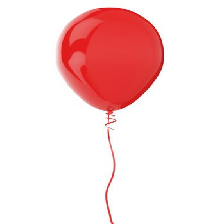

In [ ]:
from tensorflow.keras.preprocessing import image
from IPython.display import display

url = "https://cdn.education.com/files/526001_527000/526114/file_526114.jpg"
os.system("curl " + url + " > balloon.jpg")
img_path = 'balloon.jpg'
img = image.load_img(img_path, target_size=(224, 224))
display(img)

변환(에러 나면 다시 셀 실행해보기)

In [ ]:
convert(torch_model_path='torch_model.pt',
        tf_lite_model_path='tflite_model.tflite',
        image_path=img_path)



Torch to ONNX converted!




INFO:tensorflow:Assets written to: output/tf_model/assets


INFO:tensorflow:Assets written to: output/tf_model/assets




ONNX to TF converted!




TF to TFLite converted!




pytorch 모델과 tflite 모델의 output 에러 측정

In [ ]:
original_image, tf_lite_image, torch_image = get_example_input(img_path)
torch_model, tf_lite_model = init_models('torch_model.pt', 'tflite_model.tflite')

tf_lite_output = predict_tf_lite(tf_lite_model, tf_lite_image)
torch_output = predict_torch(torch_model, torch_image)
# Calculates loss metrics of outputs between two model
_ = calc_error(tf_lite_output, torch_output, verbose=True)

Mean-Square-Error between predictions: 3.5699117183685303
Mean-Absolute-Error between predictions: 1.4785114526748657



tflite 모델 output 확인

In [ ]:
from tensorflow.keras.applications.resnet50 import decode_predictions
print('Predicted:', decode_predictions(tf_lite_output, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02782093', 'balloon', 11.793416), ('n03929660', 'pick', 8.082341), ('n03291819', 'envelope', 8.027838)]
